# Part II -  Communicate Data Findings, Ford GoBike dataset
## by Gabriel Wachira

## Investigation Overview

In the investigation, I aimed at finding out the determinants or what predicted the occurrence or likelihood of a trip. I focus on the time dimension, that is trip duration and when the trips occurred. I will also focus on the riders' characteristics in the context of gender and subscription.

## Dataset Overview
The Ford GoBike dataset included information on individual rides made in a bike-sharing system covering the greater San Francisco Bay area, in February 2019. It consisted of 174,067 entries on individual trips and 20 variables describing them.

In [1]:
# upgrade seaborn if we dont have the current version installed
!pip install seaborn --upgrade

    100% |████████████████████████████████| 296kB 7.7MB/s ta 0:00:011    76% |████████████████████████▋       | 225kB 11.3MB/s eta 0:00:01
    100% |████████████████████████████████| 11.5MB 2.8MB/s eta 0:00:01  9% |███                             | 1.1MB 27.6MB/s eta 0:00:01    44% |██████████████▎                 | 5.2MB 27.6MB/s eta 0:00:01
    100% |████████████████████████████████| 13.4MB 2.5MB/s eta 0:00:01   21% |███████                         | 2.9MB 26.4MB/s eta 0:00:01    85% |███████████████████████████▍    | 11.5MB 24.3MB/s eta 0:00:01    92% |█████████████████████████████▊  | 12.5MB 25.6MB/s eta 0:00:01
    100% |████████████████████████████████| 49.4MB 813kB/s eta 0:00:01  7% |██▌                             | 3.8MB 24.1MB/s eta 0:00:02    10% |███▏                            | 5.0MB 22.3MB/s eta 0:00:02    14% |████▊                           | 7.3MB 24.0MB/s eta 0:00:02    21% |███████                         | 10.8MB 21.0MB/s eta 0:00:02    26% |████████▋              

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb
import math

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [3]:
# source of data
dataset_source = 'https://video.udacity-data.com/topher/2020/October/5f91cf38_201902-fordgobike-tripdata/201902-fordgobike-tripdata.csv'

# load in the dataset into a pandas dataframe
fordgobike = pd.read_csv('201902-fordgobike-tripdata.csv', parse_dates=True)

In [4]:
# dropping rows with null values
fordgobike.dropna(inplace=True)

In [5]:
# format the member birth year from an float to integer
fordgobike['member_birth_year'] = fordgobike['member_birth_year'].apply(math.floor)

In [6]:
# change the datatype of various columns in the dataset
formats = [
    {'datetime64[ns]' : ['start_time', 'end_time', 'member_birth_year']}, 
    {'category' : ['member_gender', 'bike_share_for_all_trip', 'user_type']}
    ]

for item in formats:
    for key, values in item.items():
        for column in values:
            fordgobike[column] = fordgobike[column].astype(str).astype(key)

In [7]:
# introduce an age column with age when rider started their trip
yr = pd.Timedelta('365.2425 days') # days in Gregorian calendar year
fordgobike['age'] = (fordgobike['start_time']- fordgobike['member_birth_year'])/yr

In [8]:
# create a column for the duration in minutes for easier interpretation
fordgobike['duration_mins'] = ((fordgobike['end_time'] - fordgobike['start_time']).dt.seconds / 60).apply(math.floor)

In [9]:
# filter out entries with age above 85
fordgobike= fordgobike[fordgobike.age<=85]

In [10]:
# filter the fordgobike dataset retaining only the interval between 0 and 100 minutes
fordgobike = fordgobike[fordgobike.duration_mins.between(0,100)]

In [11]:
# add a day column 
fordgobike['day'] = fordgobike.start_time.dt.day_name()

In [12]:
# format the column as a categorical type with the week starting on monday
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_categories = pd.api.types.CategoricalDtype(ordered = True, categories = days)
fordgobike['day'] = fordgobike.day.astype(day_categories)

In [13]:
# create a column where each trip is categorized by time of day when the tip starts
fordgobike['hour'] = fordgobike.start_time.dt.hour

In [14]:
# Classify the variables
numeric_vars = ['age', 'duration_mins','hour']
categorical_vars = ['user_type', 'member_gender', 'bike_share_for_all_trip', 'day', 'hour']

## Trip Duration Distribution

Most of the trips lasted for between 0 and 100 minutes. The majority of the trips (75%), lasted between 1 minute and 13 minutes but there is a long tail from 13 minutes onwards, up to 1409 minutes which was the longest trip.

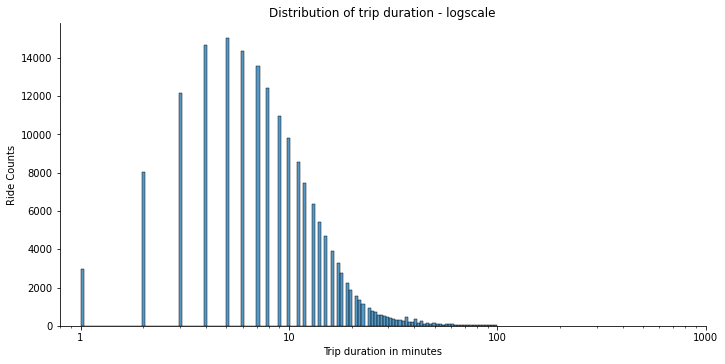

In [15]:
# x-axis on a log scale
sb.displot(data=fordgobike, x='duration_mins', height=5, aspect=2, log_scale=True)
plt.xticks(ticks=[1,10,100,1000], labels=[1,10,100,1000])
plt.ylabel('Ride Counts')
plt.xlabel('Trip duration in minutes')
plt.title('Distribution of trip duration - logscale');

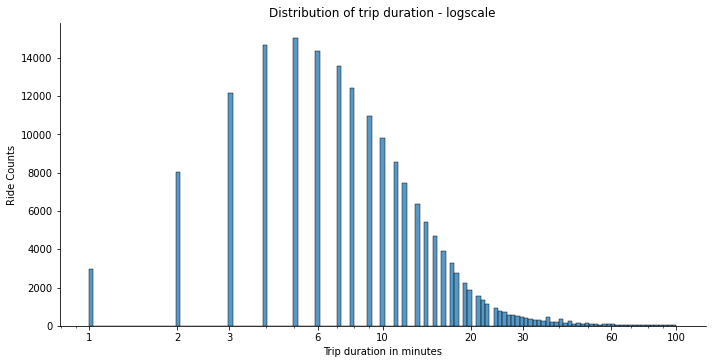

In [16]:
# plotting 0-100 interval on a logscale - x-axis logscale 
sb.displot(data=fordgobike[fordgobike.duration_mins.between(0,100)], x='duration_mins', height=5, aspect=2, log_scale=True)
plt.xticks(ticks=[1,2,3,6,10,20,30,60,100], labels=[1,2,3,6,10,20,30,60,100])
plt.ylabel('Ride Counts')
plt.xlabel('Trip duration in minutes')
plt.title('Distribution of trip duration - logscale');

## Trip Count per Day, Hour, Weekday and Weekends

<ul><li>Saturdays and Sundays were the least busy days, likely because, on weekends, fewer people were commuting to work. Thursdays were the most popular, followed by Tuesdays</li>
<li>There was a bimodal peak at 8 am and 5 pm, which coincides with the time most people are commuting in the morning and in the evening. However, the bimodal peaks at 8 am and 5 pm were not observed on weekends. Instead, a gradual rise is observed from 7 am, peaking between 1 pm and 2 pm, then a gradual decline</li> 
<li>Trips lasted longer on weekends than on weekdays. This may suggest that people rode on weekends for leisure and on weekdays to commute, or they could just have been in less of a hurry on weekends</li></ul>

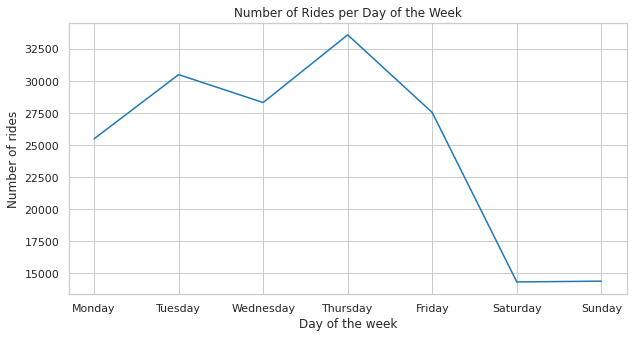

In [17]:
# group the data by the day
day_counts = fordgobike.groupby(['day'])['day'].count()

# plot a time series trend of the number of trips per hour of the day
sb.set(style='whitegrid', palette=None, rc={'figure.figsize':(10,5)})
fig, ax = plt.subplots()
day_counts.plot.line()
ax.set_xticks(np.arange(0,7,1))
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Number of Rides per Day of the Week')
plt.ylabel('Number of rides')
plt.xlabel('Day of the week');

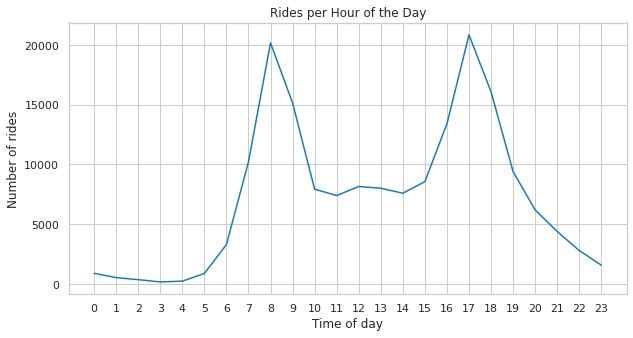

In [18]:
# group the data by the hour
hour_counts = fordgobike.groupby(['hour'])['hour'].count()

# plot a time series of the number of trips per hour of the day
hour_counts.plot.line()
plt.xticks(np.arange(0,24,1))
plt.title('Rides per Hour of the Day')
plt.ylabel('Number of rides')
plt.xlabel('Time of day');

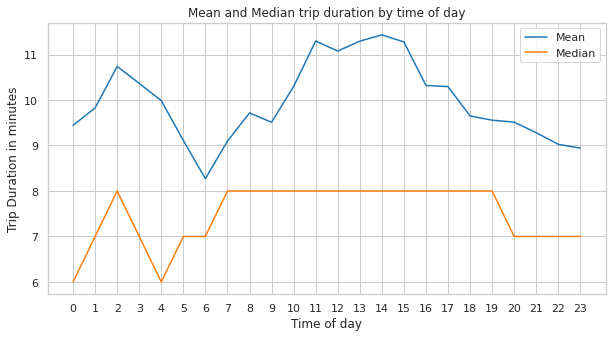

In [19]:
# mean and median trip duration comparison throughout the day
fordgobike.groupby(['hour'])['duration_mins'].mean().plot(label='Mean')
fordgobike.groupby(['hour'])['duration_mins'].median().plot(label='Median')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
plt.legend()
plt.title('Mean and Median trip duration by time of day')
plt.ylabel('Trip Duration in minutes')
plt.xlabel('Time of day');

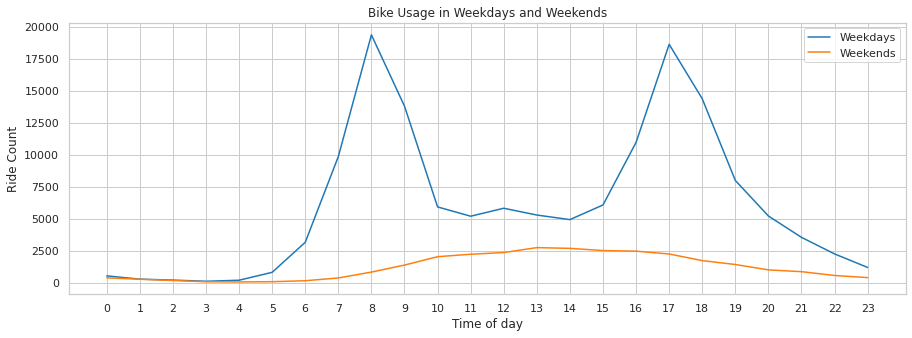

In [20]:
# weekdays
hour_counts_wedy = fordgobike[fordgobike.day.between('Monday','Friday')].groupby(['hour'])['hour'].count()
# weekends
hour_counts_wkd =fordgobike[fordgobike.day.between('Saturday','Sunday')].groupby(['hour'])['hour'].count()

# plotting
fig, ax = plt.subplots(figsize=(15,5))
hour_counts_wedy.plot.line(label='Weekdays')
hour_counts_wkd.plot.line(label='Weekends')
plt.xticks(np.arange(0,24,1))
plt.ylabel('Ride Count')
plt.legend()
plt.title('Bike Usage in Weekdays and Weekends')
plt.xlabel('Time of day');

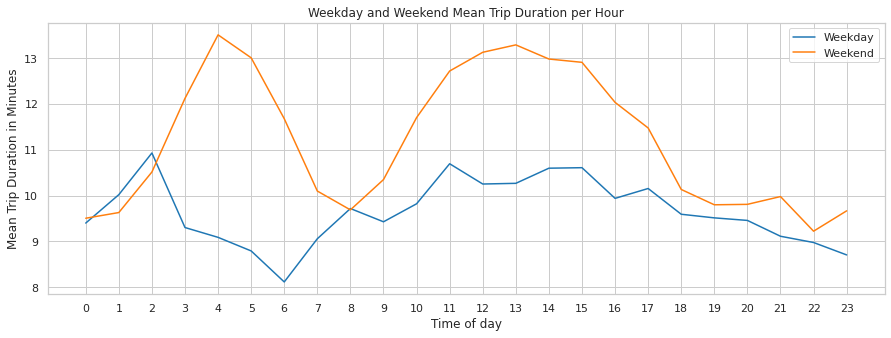

In [21]:
# weekdays
hour_means_wedy = fordgobike[fordgobike.day.between('Monday','Friday')].groupby(['hour'])['duration_mins'].mean()
# weekends
hour_means_wkd =fordgobike[fordgobike.day.between('Saturday','Sunday')].groupby(['hour'])['duration_mins'].mean()

# plotting
fig, ax = plt.subplots(figsize=(15,5))
hour_means_wedy.plot.line(label='Weekday')
hour_means_wkd.plot.line(label='Weekend')
plt.xticks(np.arange(0,24,1))
plt.ylabel('Count')
plt.legend()
plt.title('Weekday and Weekend Mean Trip Duration per Hour')
plt.ylabel('Mean Trip Duration in Minutes')
plt.xlabel('Time of day');

## Rider Characteristics by Gender and Subscription

A majority of the riders were subscribers (90%), with male users at more than 74%, females at about 23% and other genders at about 2%. 
<li>Males had shorter trip durations than females and other genders.
<li>The males however rode for a cumulative 1.26 million minutes, females for 449K minutes and other genders rode for 41K minutes. 
<li>Female customers had the longest duration of trips, while male subscribers had the shortest duration of trips.

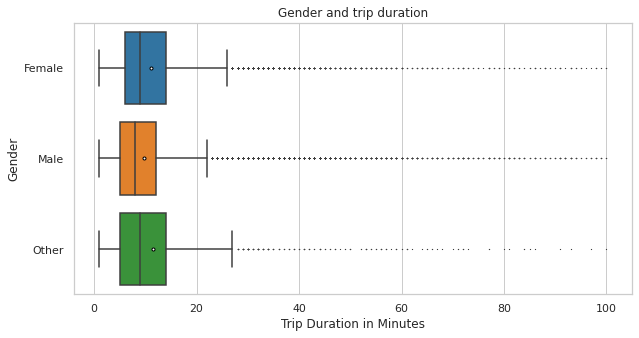

In [22]:
# gender and trip duration in minutes
box = sb.boxplot(data=fordgobike, y='member_gender', x='duration_mins', fliersize=.4, showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"3"})
plt.title('Gender and trip duration')
plt.xlabel('Trip Duration in Minutes')
plt.ylabel('Gender');

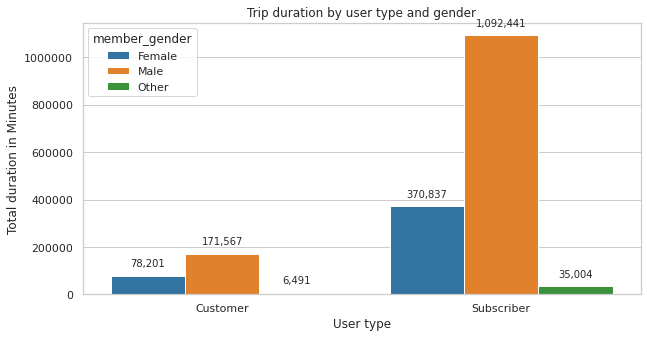

In [23]:
fig, ax = plt.subplots()

sb.barplot(data=fordgobike, hue='member_gender', y='duration_mins', x='user_type', ci=False, estimator=sum)

# add the annotation
# ax.bar_label(ax.containers[-1], fmt=',.2f', label_type='center')

# show the mean
for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h)
    text = f'{h:,.0f}'
    ax.annotate(text=text, xy=xy, ha='center', va='center', size=10, xytext = (0, 12), textcoords='offset points')

plt.ticklabel_format(style='plain', axis='y')
plt.title('Trip duration by user type and gender')
plt.ylabel('Total duration in Minutes')
plt.xlabel('User type');

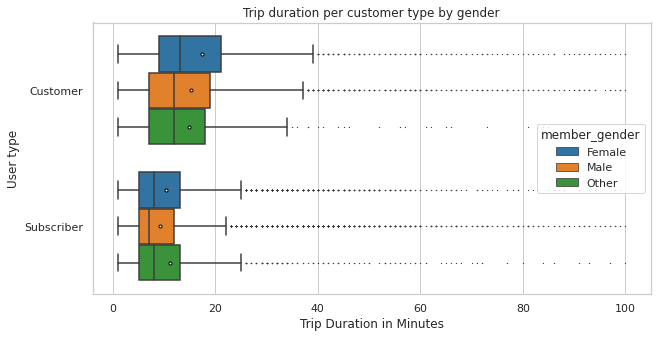

In [24]:
# user type and trip duration in minutes, disaggregated by gender
box = sb.boxplot(data=fordgobike, hue='member_gender', x='duration_mins', y='user_type', fliersize=.4, showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"3"})
plt.title('Trip duration per customer type by gender')
plt.xlabel('Trip Duration in Minutes')
plt.ylabel('User type');

In [25]:
# Use this command if you are running this file in local
!jupyter nbconvert Part_II_notebook.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] Converting notebook Part_II_notebook.ipynb to slides
[NbConvertApp] Writing 550830 bytes to Part_II_notebook.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/Part_II_notebook.slides.html
Use Control-C to stop this server
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: x-www-browser: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: firefox: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: iceweasel: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: seamonkey: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: mozilla: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: epiphany: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: konqueror: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: chromium-browser: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: google-chrome: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: www-browser: not found
